# Aplicação de CNNs para a classificação multi-label de peças de roupa

#### Descrição

Projeto final da disciplina [EEL7513-09202|EEL7514-08235|EEL510417-41000056ME/DO (20192) - Introdução ao Aprendizado de Máquina](https://moodle.ufsc.br/course/view.php?id=110125).

#### Equipe

- Kauê Cano
- Ruan Cardoso Comelli

## Inicialização

In [0]:
user = 'ruan.comelli@lepten.ufsc.br'

In [2]:
# Mount Google Drive
from pathlib import Path

from google.colab import drive

drive_path = Path('/content/drive')

drive.mount(str(drive_path))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Define paths
if user in {'ruan.comelli@lepten.ufsc.br', 'ruancomelli@gmail.com', 'rugortal@gmail.com'}:
    project_path = (
        drive_path
        / 'My Drive'
        / 'Studies'
        / '2019.3'
        / 'EEL510417 - Tópicos Especiais em Processamento de Sinais - Introdução ao Aprendizado de Máquina'
        / 'Final Project'
        / 'Codes'
    )
datasets_path = project_path / 'datasets'
deepfashion_path = datasets_path / 'DeepFashion'
fashion550k_path = datasets_path / 'Fashion550k'

models_path = project_path / 'models' # path where models are saved to
models_path.mkdir(parents=True, exist_ok=True)
log_path = project_path / 'log' # path where to export TensorBoard and the like
log_path.mkdir(parents=True, exist_ok=True)
results_path = project_path / 'results' # path where the results are stored
results_path.mkdir(parents=True, exist_ok=True)
keras_results_path = results_path / 'keras'
keras_results_path.mkdir(parents=True, exist_ok=True)

In [0]:
import sys
sys.path.append(str(project_path)) # this allows us to import modules defined locally

## Definições

### Impressão e formatação

In [0]:
def print_header(
    s: str,
    level: int = 0, 
    levels=['=', '-', '~', '*']
):
    """Standardized method for printing a section header.

    Prints the argument s underlined.
    
    Parameters
    ----------
    s      : string to be printed
    level  : index of level symbol to be used
    levels : list of level symbols to choose from
    """
    print()
    print(s)
    print(levels[level] * len(s))

### Caminhos

In [0]:
def relative_path(origin, destination):
    from os.path import relpath
    return relpath(destination, start=origin)

### Containers

In [0]:
def missing_elements(int_list): # source: adapted from <https://stackoverflow.com/questions/16974047/efficient-way-to-find-missing-elements-in-an-integer-sequence>
    # find missing elements in a list of integers
    int_list = sorted(int_list)
    if int_list:
        start, end = int_list[0], int_list[-1]
        full_list = set(range(start, end + 1))
        return sorted(full_list.difference(int_list))
    else:
        return set([])
    
def merge_dicts(*dict_args):
    """
    Given any number of dicts, shallow copy and merge into a new dict,
    precedence goes to key value pairs in latter dicts.
    """
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result

def extract_value(dicts, key, default_behaviour='value', default=None):
    # extract values from dictionaries using a single key
    if isinstance(dicts, dict):
        dicts = [dicts]
    
    for d in dicts:
        if key in d:
            return d[key]
        
    default_behaviour = default_behaviour.lower()
        
    if default_behaviour == 'value':
        return default
    elif default_behaviour == 'raise':
        raise ValueError(f'key {key} was not found in the dictionaries.')
    else:
        raise ValueError(f'default_behaviour must be either \'value\' or \'raise\'. Got \'{default_behaviour}\'.')

def extract_values(dicts, keys, default_behaviour='value', default=None):
    # extract values from dictionaries using multiple keys
    if isinstance(dicts, dict):
        dicts = [dicts]
    
    return {
        key: extract_value(dicts, key, default_behaviour='value', default=default)
        for key in keys
    }

### Valores *default*

In [0]:
def regularize_default(
    x, cond, default,
    many=False, many_cond=False, many_default=False,
    call_default=False
):
    # Manage default arguments and passed parameters
    from itertools import repeat

    if many:
        cond = cond if many_cond else repeat(cond)
        default = default if many_default else repeat(default)

        return (
            regularize_default(
                x_, cond_, default_,
                many=False, many_cond=False, many_default=False,
                call_default=call_default
            )
            for x_, cond_, default_ in zip(x, cond, default)
        )

    if cond(x):
        return x
    else:
        if call_default:
            return default()
        else:
            return default

### Gerenciador de modelos

In [0]:
from pathlib import Path
import json

# ModelManager is a class design for automating the process of creating, saving and loading models.
# By means of the function provide_model, the manager will first check if any models were already
# created and trained using the given parameters. If so, the model is not retrained, but only loaded
# from disk.
class ModelManager:
    def __init__(
        self,
        models_path=None,
        table_path=None,
        encoding='utf-8',
        load_table=True,
        file_name_fmt='{index}.data',
        creator_method=None,
        creator_name=None,
        save_method=None,
        load_method=None
    ):
        def default_save_method(model, path):
            import pickle
            with path.open('wb') as file:
                pickle.dump(model, file, protocol=pickle.HIGHEST_PROTOCOL)

        def default_load_method(path):
            import pickle
            with path.open('rb') as file:
                return pickle.load(file)

        if models_path is None:
            models_path = Path('.') / 'models'
        self.models_path = Path(models_path).resolve()

        if table_path is None:
            table_path = (models_path / 'lookup_table.json').resolve()
        self.table_path = table_path

        self.encoding = encoding

        if load_table:
            self.load_lookup_table()
        
        self.file_name_fmt = file_name_fmt
        self.creator_method = creator_method
        self.creator_name = creator_name

        if save_method is None:
            self.save_method = default_save_method
        else:
            self.save_method = save_method

        if load_method is None:
            self.load_method = default_load_method
        else:
            self.load_method = load_method

    def initialize_lookup_table(self):
        self.table_path.parent.mkdir(parents=True, exist_ok=True)
        with self.table_path.open('w', encoding=self.encoding) as lookup_table_file:
            json.dump(dict(files={}), lookup_table_file, indent=4, ensure_ascii=False)

        return self

    def load_lookup_table(self):
        if not self.table_path.exists():
            self.initialize_lookup_table()
        with self.table_path.open('r', encoding=self.encoding) as lookup_table_file:
            try:
                self.lookup_table = json.load(lookup_table_file)
            except json.JSONDecodeError:
                self.initialize_lookup_table()
                return self.load_lookup_table()
        
        return self

    def save_lookup_table(self, table_path=None):
        if table_path is not None:
            self.table_path = table_path

        with self.table_path.open('w', encoding='utf-8') as lookup_table_file:
            json.dump(self.lookup_table, lookup_table_file, indent=4)
            
        return self

    def model_path(self, params, include=True):
        import json

        def as_json(obj):
            return json.loads( json.dumps(obj) )

        file_dict = self.lookup_table['files']
        for file_name, content in file_dict.items():
            if as_json(content) == as_json(params):
                break
        else:
            int_key_list = [int(Path(key).stem) for key in file_dict]
            missing_elems = missing_elements(int_key_list)
            if missing_elems:
                index = missing_elems[0]
            else:
                index = str(max(int_key_list, default=-1) + 1)
            file_name = self.file_name_fmt.format(index=index)

        file_path = (self.models_path / file_name).resolve().absolute()
        
        key = relative_path(self.table_path.parent, file_path)

        if include:
            file_dict[key] = params

        self.save_lookup_table()
        
        return file_path

    def delete_model(self, params):
        for file_name, content in self.lookup_table['files'].items():
            if content == params:
                break

        self.lookup_table['files'].pop(file_name)
        self.model_path(params).unlink()

    def save_model(self, model, path=None, params=None):
        if path is None:
            path = self.model_path(params)

        path.parent.mkdir(parents=True, exist_ok=True)

        self.save_method(model, path)
            
        return self

    def load_model(self, path):
        return self.load_method(path)

    def provide_model(
        self,
        creator_method=None,
        creator_name=None,
        params=None,
        hidden_params=None,
        save: bool = False,
        load: bool = False):

        import pickle
        
        if creator_method is None:
            creator_method = self.creator_method

        if params is None:
            params = {}
        if hidden_params is None:
            hidden_params = {}
        if creator_name is None:
            if hasattr(creator_method, 'creator_name') and creator_method.creator_name is not None:
                creator_name = creator_method.creator_name
            elif self.creator_name is not None:
                creator_name = self.creator_name
            else:
                creator_name = repr(creator_method)
        
        path = self.model_path({
            'creator': creator_name,
            'parameters': params
        })

        print(f'Model path = {path}')

        if load:
            try:
                print('Trying to load')
                return self.load_model(path)
            except (FileNotFoundError, pickle.UnpicklingError, OSError):
                print('Load failed')
                pass

        model = creator_method(merge_dicts(params, hidden_params))

        if save:
            self.save_model(model, path)

        return model

# ModelCreator facilitates the interface between creator functions and the ModelManager.
# A creator function is any function that takes parameters (or a dict of parameters) and
# outputs a model (trained or not, compiled or not) and, possibly, additional values such
# that training history
class ModelCreator:
    def __init__(
        self,
        creator_method,
        creator_name=None,
        default_params=None,
        expand_params: bool = False
    ):
        self.default_params = default_params if default_params is not None else {}
        self.expand_params = expand_params
        self.creator_method = creator_method
        self.creator_name = creator_name
        
    def __call__(self, params=None):
        if params is None:
            params = {}
            
        params = merge_dicts(self.default_params, params)
        
        if self.expand_params:
            return self.creator_method(**params)
        else:
            return self.creator_method(params)

### Métricas customizadas

In [10]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.python.keras.losses import LossFunctionWrapper
from tensorflow.python.keras.metrics import MeanMetricWrapper

# References:
# https://stackoverflow.com/questions/49007163/keras-get-true-negative-from-y-true-and-y-pred
# https://stackoverflow.com/questions/38036588/tensorflow-with-gpu-and-cuda-v5-5
# https://www.tensorflow.org/install/gpu
# https://github.com/tensorflow/models/tree/master/research/global_objectives
# https://arxiv.org/abs/1608.04802
# https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
# https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/70328
# https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/77289
# https://stats.stackexchange.com/questions/359909/is-accuracy-an-improper-scoring-rule-in-a-binary-classification-setting
# https://stackoverflow.com/questions/53354176/how-to-use-f-score-as-error-function-to-train-neural-networks

class custom_metrics:
    class probabilistic:
        @staticmethod
        def true_positives(y_true, y_pred):
            return K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
        
        @staticmethod
        def true_negatives(y_true, y_pred):
            return K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
        
        @staticmethod
        def false_positives(y_true, y_pred):
            return K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
        
        @staticmethod
        def false_negatives(y_true, y_pred):
            return K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
        
        @staticmethod
        def confusion(y_true, y_pred):
            return {
                'true_positives': custom_metrics.probabilistic.true_positives(y_true, y_pred),
                'true_negatives': custom_metrics.probabilistic.true_negatives(y_true, y_pred),
                'false_positives': custom_metrics.probabilistic.false_positives(y_true, y_pred),
                'false_negatives': custom_metrics.probabilistic.false_negatives(y_true, y_pred)
            }

        def precision(y_true, y_pred):
            tp = custom_metrics.probabilistic.true_positives(y_true, y_pred)
            fp = custom_metrics.probabilistic.false_positives(y_true, y_pred)

            return tp / (tp + fp + K.epsilon())

        def recall(y_true, y_pred):
            tp = custom_metrics.probabilistic.true_positives(y_true, y_pred)
            fn = custom_metrics.probabilistic.false_negatives(y_true, y_pred)

            return tp / (tp + fn + K.epsilon())
            
        @staticmethod
        def f_score(y_true, y_pred, beta=1.0):
            # Source: https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
            p = custom_metrics.probabilistic.precision(y_true, y_pred)
            r = custom_metrics.probabilistic.recall(y_true, y_pred)

            f = (1 + beta**2)*p*r / (p*beta**2 + r + K.epsilon())
            f = tf.where(tf.is_nan(f), tf.zeros_like(f), f)

            return K.mean(f)

        @staticmethod
        def f1_score(y_true, y_pred):
            return custom_metrics.probabilistic.f_score(y_true, y_pred, beta=1.0)

        @staticmethod
        def f_loss(y_true, y_pred, beta=1.0):
            return 1 - custom_metrics.probabilistic.f_score(y_true, y_pred, beta)
            
        @staticmethod
        def f1_loss(y_true, y_pred):
            return custom_metrics.probabilistic.f_loss(y_true, y_pred, beta=1.0)

    class classification:
        @staticmethod
        def true_positives(y_true, y_pred):
            return K.sum(K.round(K.clip(y_true*y_pred, 0, 1)))

        @staticmethod
        def true_negatives(y_true, y_pred):
            return K.sum(K.round(K.clip((1-y_true)*(1-y_pred), 0, 1)))
            
        @staticmethod
        def false_positives(y_true, y_pred):
            return K.sum(K.round(K.clip((1-y_true)*y_pred, 0, 1)))
            
        @staticmethod
        def false_negatives(y_true, y_pred):
            return K.sum(K.round(K.clip(y_true*(1-y_pred), 0, 1)))
        
        @staticmethod
        def confusion(y_true, y_pred):
            return {
                'true_positives': custom_metrics.classification.true_positives(y_true, y_pred),
                'true_negatives': custom_metrics.classification.true_negatives(y_true, y_pred),
                'false_positives': custom_metrics.classification.false_positives(y_true, y_pred),
                'false_negatives': custom_metrics.classification.false_negatives(y_true, y_pred)
            }

        def precision(y_true, y_pred):
            tp = custom_metrics.classification.true_positives(y_true, y_pred)
            fp = custom_metrics.classification.false_positives(y_true, y_pred)

            return tp / (tp + fp + K.epsilon())

        def recall(y_true, y_pred):
            tp = custom_metrics.classification.true_positives(y_true, y_pred)
            fn = custom_metrics.classification.false_negatives(y_true, y_pred)

            return tp / (tp + fn + K.epsilon())
            
        @staticmethod
        def f_score(y_true, y_pred, beta=1.0):
            # Source: https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
            p = custom_metrics.classification.precision(y_true, y_pred)
            r = custom_metrics.classification.recall(y_true, y_pred)

            f = (1 + beta**2)*p*r / (p*beta**2 + r + K.epsilon())
            f = tf.where(tf.is_nan(f), tf.zeros_like(f), f)
            return K.mean(f)

        @staticmethod
        def f1_score(y_true, y_pred):
            return custom_metrics.classification.f_score(y_true, y_pred, beta=1.0)

class FScore(MeanMetricWrapper):
    def __init__(
        self,
        beta=1.0,
        name='f_score',
        dtype=None
    ):
        from functools import partial
        super(FScore, self).__init__(
            partial(custom_metrics.probabilistic.f_score, beta=beta),
            name=name,
            dtype=dtype
        )
        self.beta = beta

class F1Score(MeanMetricWrapper):
    def __init__(
        self,
        name='f1_score',
        dtype=None
    ):
        super(F1Score, self).__init__(
            custom_metrics.probabilistic.f1_score,
            name=name,
            dtype=dtype
        )

class FLoss(LossFunctionWrapper):
    def __init__(
        self,
        beta=1.0,
        name='f_loss'
    ):
        from functools import partial
        super(FLoss, self).__init__(
            partial(custom_metrics.probabilistic.f_loss, beta=beta),
            name=name
        )
        self.beta = beta

class F1Loss(LossFunctionWrapper):
    def __init__(
        self,
        name='f1_loss'
    ):
        super(F1Loss, self).__init__(
            custom_metrics.probabilistic.f1_loss,
            name=name
        )

## Configuração

In [0]:
DATA_FORMAT = 'channels_last'
IMG_SIZE = (224, 224)
IMG_SHAPE = (
    IMG_SIZE + (3,)
    if DATA_FORMAT == 'channels_last'
    else (3,) + IMG_SIZE
)
BATCH_SIZE = 16
RESCALE = 1./255
FILL_MODE = 'nearest'

validate_filenames = True

augment_previously = True
fill_aug_imgs = False

# DeepFashion

## Preparação

### Importar dados

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

# more paths
category_attribute_prediction_path = (deepfashion_path / 'Category and Attribute Prediction Benchmark').absolute().resolve()
images_path = (category_attribute_prediction_path / 'Img').absolute().resolve()
augmented_imgs_path = (category_attribute_prediction_path / 'Img' / 'aug_img').absolute().resolve()
annotations_path = (category_attribute_prediction_path / 'Anno').absolute().resolve()
evaluation_path = (category_attribute_prediction_path / 'Eval').absolute().resolve()

dataset_anno_path = annotations_path / 'dataset.csv'
dataset_path = (category_attribute_prediction_path / 'Img' / 'dataset').absolute().resolve()
dataset_path.mkdir(parents=True, exist_ok=True)

# n_categories = int(pd.read_csv(annotations_path / 'list_category_cloth.txt', nrows=1, header=None)[0][0])
# categories = pd.read_csv(annotations_path / 'list_category_cloth.txt', skiprows=1, delimiter=r"\s\s+", engine='python')
# categories = categories.astype({
#     'category_name': str,
#     'category_type': int
# })
# category_types = {
#     1: 'upper-body clothes',
#     2: 'lower-body clothes',
#     3: 'full-body clothes'
# }

# n_category_imgs = int(pd.read_csv(annotations_path / 'list_category_img.txt', nrows=1, header=None)[0][0])
# category_imgs = pd.read_csv(annotations_path / 'list_category_img.txt', skiprows=1, delim_whitespace=True)
# category_imgs = category_imgs.astype({
#     'image_name': str,
#     'category_label': int
# })

n_attributes = int(pd.read_csv(annotations_path / 'list_attr_cloth.txt', nrows=1, header=None)[0][0])
attributes = pd.read_csv(annotations_path / 'list_attr_cloth.txt', skiprows=1, delimiter=r"\s\s+", engine='python')
attributes = attributes.astype({
    'attribute_name': str,
    'attribute_type': int
})
attribute_types = {
    1: 'texture-related attributes',
    2: 'fabric-related attributes',
    3: 'shape-related attributes',
    4: 'part-related attributes',
    5: 'style-related attributes'
}

# define the binarizer that maps from a binary representation to lists of strings, each one
# a category
attr_binarizer = MultiLabelBinarizer()
attr_binarizer.fit([attributes['attribute_name']])
n_labels = attr_binarizer.classes_.size
print(n_labels, 'classes found:', attr_binarizer.classes_)

1000 classes found: ['a-line' 'abstract' 'abstract chevron' 'abstract chevron print'
 'abstract diamond' 'abstract floral' 'abstract floral print'
 'abstract geo' 'abstract geo print' 'abstract paisley' 'abstract pattern'
 'abstract print' 'abstract printed' 'abstract stripe' 'acid' 'acid wash'
 'americana' 'angeles' 'animal' 'animal print' 'ankle' 'applique'
 'arrow collar' 'art' 'asymmetric' 'asymmetrical' 'asymmetrical hem'
 'athletic' 'audrey' 'babe' 'babydoll' 'back bow' 'back cutout'
 'back knit' 'back lace' 'back striped' 'backless' 'baja' 'bandage'
 'bandana' 'bandana print' 'barbie' 'baroque' 'baroque print' 'baseball'
 'basic' 'basquiat' 'batwing' 'beach' 'bead' 'beaded' 'beaded chiffon'
 'beaded collar' 'beaded sheer' 'beaded shift' 'beatles' 'bed' 'bejeweled'
 'bell' 'bell-sleeve' 'bella' 'belted' 'belted chiffon' 'belted floral'
 'belted floral print' 'belted lace' 'belted maxi' 'belted plaid'
 'bermuda' 'bib' 'big' 'bike' 'biker' 'bird' 'bird print' 'blah' 'bleach'
 'blea

### Data augmentation

In [13]:
from ast import literal_eval
from tensorflow.keras.preprocessing.image import save_img
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator

n_attribute_imgs = int(pd.read_csv(annotations_path / 'list_attr_img.txt', nrows=1, header=None)[0][0])
column_names = pd.read_csv(annotations_path / 'list_attr_img.txt', skiprows=1, nrows=1, delim_whitespace=True, header=None).values[0]

# due to the time taken by the models to load images from disk and preprocess them,
# the ideia to augment data previous to everything came up.
previously_augmented = False
if augment_previously:
    attribute_aug_imgs_path = annotations_path / 'attribute_aug_imgs.txt'
    try:
        # in this case, images were already preprocessed, and we can load them directly
        print('Trying to read augmented image attributes', end='')
        attribute_aug_imgs = pd.read_csv(attribute_aug_imgs_path)
        attribute_aug_imgs[column_names[1]] = attribute_aug_imgs[column_names[1]].apply(lambda x: list(y for y in literal_eval(x)))

        attribute_aug_imgs = attribute_aug_imgs.astype({
            column_names[0]: str,
            column_names[1]: object
        })

        print(' - Done')
    except (FileNotFoundError, pd.errors.EmptyDataError):
        # if the file does not exist, it means that we did no data augmentation as yet
        print(' - File not found... augmenting images later')
        attribute_aug_imgs = pd.DataFrame(columns=column_names)
        attribute_aug_imgs.to_csv(attribute_aug_imgs_path, index=False)

    n_attribute_aug_imgs = len(attribute_aug_imgs.index)
    if fill_aug_imgs:
        previously_augmented = (n_attribute_aug_imgs == n_attribute_imgs)
    else:
        previously_augmented = True

if not augment_previously or not previously_augmented:
    attribute_imgs_path = annotations_path / 'attribute_imgs.txt'
    try:
        # create a pandas.DataFrame mapping non-augmented images to their y-value in the sparse format
        print('Trying to read image attributes', end='')
        attribute_imgs = pd.read_csv(attribute_imgs_path)
        attribute_imgs[column_names[1]] = attribute_imgs[column_names[1]].apply(lambda x: list(y for y in literal_eval(x)))
        print(' - Done')
    except (FileNotFoundError, pd.errors.EmptyDataError):
        # if the previous file does not exist, we need to use the original data, in which the y-values are
        # in binary format (and much more memory consuming)
        print(' - File not found... reading in chunks from bigger file')
        first_row = pd.read_csv(annotations_path / 'list_attr_img.txt', skiprows=2, nrows=1, delim_whitespace=True, header=None).values[0]
        attribute_imgs = pd.DataFrame(columns=column_names)
        for i, chunk in enumerate(pd.read_csv(
                annotations_path / 'list_attr_img.txt',
                skiprows=2,
                delim_whitespace=True,
                header=None,
                chunksize=50000,
                converters={
                    col: lambda x: True if x == '1' else False if x == '-1' else x
                    for col in range(1, len(first_row))
                }
        )):
            print(f'Reading chunk #{i}', end='')

            chunk = list(chunk.itertuples())
            y_values = [
                list(
                    idx
                    for idx, value in enumerate(row[2:])
                    if value
                ) for row in chunk
            ]
            chunk = pd.DataFrame({
                column_names[0]: [images_path / row[1] for row in chunk],
                column_names[1]: [[attributes['attribute_name'][y_] for y_ in y_value] if y_value else ['none'] for y_value in y_values]
            }, index=[row[0] for row in chunk])

            attribute_imgs = attribute_imgs.append(chunk, verify_integrity=True, sort=False)

            print(f' - Done')
        try:
            print('Trying to write attribute images', end='')
            attribute_imgs.to_csv(attribute_imgs_path, index=False)
            print(' - Done')
        except PermissionError:
            print(' - Permission denied')

    attribute_imgs = attribute_imgs.astype({
        column_names[0]: str,
        column_names[1]: object
    })

# Binarizer that takes de 'none' class into account
expanded_attr_binarizer = MultiLabelBinarizer()
if not augment_previously or not previously_augmented:
    expanded_attr_binarizer.fit(attribute_imgs[column_names[1]])
else:
    expanded_attr_binarizer.fit(attribute_aug_imgs[column_names[1]])

if augment_previously and not previously_augmented:
    # perform previous data augmentation
    print('Augmenting images')

    image_data_generator = ImageDataGenerator(
        rescale=RESCALE,
        data_format=DATA_FORMAT,
        fill_mode=FILL_MODE,
    )
    augmented_imgs_path.mkdir(parents=True, exist_ok=True)

    dataframe_iterator = image_data_generator.flow_from_dataframe(
        attribute_imgs[n_attribute_aug_imgs:],
        x_col=column_names[0],
        y_col=column_names[1],
        color_mode='rgb',
        classes=list(expanded_attr_binarizer.classes_),
        class_mode='categorical',
        validate_filenames=validate_filenames,
        shuffle=False,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )
    counter = n_attribute_aug_imgs
    break_all = False
    for batch in dataframe_iterator:
        print_header(f'Batch {dataframe_iterator.batch_index}')
        for idx, (X, y) in enumerate(zip(*batch)):
            y = np.expand_dims(y, axis=0)
            inv_y = expanded_attr_binarizer.inverse_transform(y)
            
            origin = Path(dataframe_iterator.filenames[idx])
            file_path = augmented_imgs_path / origin.parts[-2] / origin.parts[-1]
            
            print(f'Index = {counter}/{n_attribute_imgs} [#{idx} from batch {dataframe_iterator.batch_index}]')
            print(f'Origin = {origin}')
            print(f'y = {inv_y} [path = {file_path}]')

            file_path.parent.mkdir(parents=True, exist_ok=True)
            if not file_path.exists():
                save_img(file_path, X)
            attribute_aug_imgs = attribute_aug_imgs.append({
                column_names[0]: str(file_path),
                column_names[1]: inv_y[0]
            }, ignore_index=True)

            counter += 1
            if counter == n_attribute_imgs:
                break_all = True
                break

        attribute_aug_imgs.to_csv(attribute_aug_imgs_path, index=False)
        if break_all:
            break

    previously_augmented = True
    print('Done')

Trying to read augmented image attributes - Done


### Informação

In [14]:
# print_header('Categories')
# print(f'n_categories = {n_categories}')
# categories.info()
# categories.head()
# print('Category types:', category_types)

# print_header('Category images')
# print(f'n_category_imgs = {n_category_imgs}')
# category_imgs.info()
# category_imgs.head()

print_header('Attributes')
print(f'n_attributes = {n_attributes}')
attributes.info()
attributes.head()
print('Category types:', attribute_types)

if not augment_previously or not previously_augmented:
    print_header('Attribute images')
    print(f'n_attribute_imgs = {n_attribute_imgs}')
    attribute_imgs.info()
    attribute_imgs.head()

if previously_augmented:
    print_header('Augmented Attribute images')
    print(f'n_attribute_imgs = {n_attribute_imgs}')
    attribute_aug_imgs.info()
    attribute_aug_imgs.head()


Attributes
n_attributes = 1000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
attribute_name    1000 non-null object
attribute_type    1000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
Category types: {1: 'texture-related attributes', 2: 'fabric-related attributes', 3: 'shape-related attributes', 4: 'part-related attributes', 5: 'style-related attributes'}

Augmented Attribute images
n_attribute_imgs = 289222
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125671 entries, 0 to 125670
Data columns (total 2 columns):
image_name          125671 non-null object
attribute_labels    125671 non-null object
dtypes: object(2)
memory usage: 1.9+ MB


## Conjunto de dados

### Geração do conjunto de dados

In [15]:
from sklearn.model_selection import train_test_split

# Setup ============================
dataset_size = 10000
# problem = 'category'
problem = 'attribute'
from_file = False # keep it False!
# ==================================

if from_file:
    try:
        dataset = pd.read_csv(dataset_anno_path)
        from_file_success = True
    except FileNotFoundError:
        from_file_success = False

if (not from_file) or (not from_file_success):
    if problem == 'attribute':
        if previously_augmented:
            dataset = attribute_aug_imgs
        else:
            dataset = attribute_imgs
    elif problem == 'category':
        if previously_augmented:
            dataset = category_aug_imgs
        else:
            dataset = category_imgs

    dataset, _ = train_test_split(dataset, train_size=dataset_size)

# create a reduced dataset
if from_file and not from_file_success:
    dataset_iter = ImageDataGenerator(
        data_format=DATA_FORMAT,
        fill_mode=FILL_MODE,
    ).flow_from_dataframe(
        dataset,
        x_col=column_names[0],
        y_col=column_names[1],
        color_mode='rgb',
        classes=list(expanded_attr_binarizer.classes_),
        class_mode='categorical',
        validate_filenames=validate_filenames,
        shuffle=False,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    counter = 0
    break_all = False
    for batch in dataset_iter:
        print_header(f'Batch {dataset_iter.batch_index}')
        idx = 0
        for in_batch_idx, (X, y) in enumerate(zip(*batch)):
            y = np.expand_dims(y, axis=0)
            inv_y = expanded_attr_binarizer.inverse_transform(y)
            
            origin = Path(dataset_iter.filenames[idx])
            file_path = dataset_path / origin.parts[-2] / origin.parts[-1]
            
            print(f'Index = {counter}/{len(dataset.index)} [#{in_batch_idx} from batch {dataset_iter.batch_index}]')
            print(f'Origin = {origin}')
            print(f'y = {inv_y} [path = {file_path}]')

            file_path.parent.mkdir(parents=True, exist_ok=True)
            if not file_path.exists():
                save_img(file_path, X)

            idx += 1
            counter += 1
            if counter == len(dataset.index):
                break_all = True
                break

        if break_all:
            break

    from pathlib import Path

    dataset[column_names[0]] = dataset[column_names[0]].apply(
        lambda file_path: relative_path(
            images_path,
            dataset_path / Path(file_path).parts[-2] / Path(file_path).parts[-1]
        )
    )
    dataset.to_csv(dataset_anno_path, index=False)

# split the dataset into training, validation and testing sets
val_size = 0.2
test_size = 0.2
train_set, test_set = train_test_split(dataset, test_size=test_size)
train_set, val_set = train_test_split(train_set, test_size=val_size/(1 - test_size))

total = sum(data.shape[0] for data in (train_set, val_set, test_set))
for name, data in (('Train set', train_set), ('Validation set', val_set), ('Test set', test_set)):
    print(f'{name} shape: {data.shape} [{100*data.shape[0]/total:.0f}% of data]')

dataset.info()
dataset.head()
train_set.info()
train_set.head()
val_set.info()
val_set.head()
test_set.info()
test_set.head()

Train set shape: (6000, 2) [60% of data]
Validation set shape: (2000, 2) [20% of data]
Test set shape: (2000, 2) [20% of data]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 21838 to 113846
Data columns (total 2 columns):
image_name          10000 non-null object
attribute_labels    10000 non-null object
dtypes: object(2)
memory usage: 234.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 34117 to 74412
Data columns (total 2 columns):
image_name          6000 non-null object
attribute_labels    6000 non-null object
dtypes: object(2)
memory usage: 140.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 114114 to 16737
Data columns (total 2 columns):
image_name          2000 non-null object
attribute_labels    2000 non-null object
dtypes: object(2)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 8435 to 51646
Data columns (total 2 columns):
image_name          2000 non-null object
attribute_lab

,image_name,attribute_labels
8435,/content/drive/My Drive/Studies/2019.3/EEL5104...,"[pocket, zip]"
47121,/content/drive/My Drive/Studies/2019.3/EEL5104...,[taco]
38331,/content/drive/My Drive/Studies/2019.3/EEL5104...,"[loose, printed]"
85207,/content/drive/My Drive/Studies/2019.3/EEL5104...,"[cotton, lady, red, stripe, zipper]"
38966,/content/drive/My Drive/Studies/2019.3/EEL5104...,[none]


### Geradores de dados

In [16]:
rescale = 0 if previously_augmented else RESCALE

# define generators
train_datagen = ImageDataGenerator(
    rescale=rescale,
    data_format=DATA_FORMAT,
    fill_mode=FILL_MODE,
    # validation_split=0.0,
)
test_datagen = ImageDataGenerator(
    rescale=rescale,
    data_format=DATA_FORMAT,
    fill_mode=FILL_MODE,
)

train_gen = train_datagen.flow_from_dataframe(
    train_set,
    x_col=column_names[0],
    y_col=column_names[1],
    color_mode='rgb',
    classes=list(attr_binarizer.classes_),
    class_mode='categorical',
    validate_filenames=validate_filenames,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_gen = test_datagen.flow_from_dataframe(
    val_set,
    x_col=column_names[0],
    y_col=column_names[1],
    color_mode='rgb',
    classes=list(attr_binarizer.classes_),
    class_mode='categorical',
    validate_filenames=validate_filenames,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
test_gen = test_datagen.flow_from_dataframe(
    test_set,
    x_col=column_names[0],
    y_col=column_names[1],
    color_mode='rgb',
    classes=list(attr_binarizer.classes_),
    class_mode='categorical',
    validate_filenames=validate_filenames,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 5709 validated image filenames belonging to 1000 classes.
Found 1891 validated image filenames belonging to 1000 classes.
Found 1901 validated image filenames belonging to 1000 classes.


## Modelos

### Gerenciamento automático de modelos

In [0]:
# define new save and load methods to use with ModelManager

def save_serialized(save_map):
    def save(return_dict, path):
        for key, obj in return_dict.items():
            path_ = path.with_suffix(path.suffix + '.' + key)

            save_map[key](obj, path_)
    return save

def save_keras_model(keras_model, path):
    keras_model.save(str(path.absolute().resolve()))

def save_pkl(obj, path):
    import pickle

    with path.absolute().resolve().open('wb') as file:
        pickle.dump(obj, file, protocol=pickle.HIGHEST_PROTOCOL)

save_map = {
    'model': save_keras_model,
    'history': save_pkl
}

def load_serialized(load_map):
    def load(path):
        loaded = {}
        for key, loader in load_map.items():
            path_ = path.with_suffix(path.suffix + '.' + key)
            loaded[key] = loader(path_)
            
        return loaded
    return load

def load_keras_model(path):
    from tensorflow.keras.models import load_model

    return load_model(
        str(path.absolute().resolve()),
        custom_objects={
            'F1Score': F1Score,
            'f1_score': custom_metrics.probabilistic.f1_score
        }
    )

def load_pkl(path):
    import pickle

    with path.absolute().resolve().open('rb') as file:
        return pickle.load(file)

load_map = {
    'model': load_keras_model,
    'history': load_pkl
}

manager = ModelManager(
    models_path=models_path,
    file_name_fmt='{index}.model',
    save_method=save_serialized(save_map),
    load_method=load_serialized(load_map)
)

In [0]:
# map strings to objects aiming to facilitate the use o

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.resnet import ResNet152
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

application_dict = {
    'Xception': Xception,
    'VGG16': VGG16,
    'VGG19': VGG19,
    'ResNet50': ResNet50,
    'ResNet101': ResNet101,
    'ResNet152': ResNet152,
    'ResNet50V2': ResNet50V2,
    'ResNet101V2': ResNet101V2,
    'ResNet152V2': ResNet152V2,
    'InceptionV3': InceptionV3,
    'InceptionResNetV2': InceptionResNetV2,
    'MobileNet': MobileNet,
    'DenseNet121': DenseNet121,
    'DenseNet169': DenseNet169,
    'DenseNet201': DenseNet201,
    'NASNetLarge': NASNetLarge,
    'NASNetMobile': NASNetMobile,
    'MobileNetV2': MobileNetV2,
}

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.optimizers import Nadam

optimizer_dict = {
    'SGD': SGD,
    'RMSprop': RMSprop,
    'Adagrad': Adagrad,
    'Adadelta': Adadelta,
    'Adam': Adam,
    'Adamax': Adamax,
    'Nadam': Nadam,
}


from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

callback_dict = {
    'ModelCheckpoint': ModelCheckpoint,    
    'ReduceLROnPlateau': ReduceLROnPlateau,
    'TensorBoard': TensorBoard,
    'EarlyStopping': EarlyStopping,
}

from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2

regularizer_dict = {
    'l1': l1,
    'l2': l2,
}

### Treinamento

In [19]:
# creator method: creates a model, compiles it and fits it, return (model, history)
def creator_method(
    dataset_size,
    base_net,
    base_net_dict,
    base_net_params,
    optimizer_name,
    optimizer_dict,
    optimizer_params,
    loss,
    loss_dict,
    negative_class_weight,
    positive_class_weight,
    metrics_names,
    metrics_dict,
    train_gen,
    val_gen,
    callback_dict,
    callback_params,
    fit_params
):
    model = base_net_dict[base_net](**base_net_params)

    Optimizer = optimizer_dict[optimizer_name]
    optimizer = Optimizer(**optimizer_params)

    model.compile(
        optimizer,
        loss=loss_dict[loss],
        metrics=[metrics_dict[name] for name in metrics_names]
    )

    model.summary()

    history = model.fit_generator(
        generator=train_gen,
        validation_data=val_gen,
        class_weight=merge_dicts(
            {'none': negative_class_weight, n_labels: negative_class_weight},
            {cls: positive_class_weight for cls in attr_binarizer.classes_},
            {cls: positive_class_weight for cls in range(n_labels)}
        ),
        callbacks=[
            callback_dict[name](**params)
            for name, params in callback_params.items()
        ],
        **fit_params
    )

    return_dict = {
        'model': model,
        'history': history.history
    }

    return return_dict

# wrap creator_method
model_creator = ModelCreator(
    creator_method,
    creator_name='model_creator',
    expand_params=True
)

loss_dict = {
    'binary_crossentropy': 'binary_crossentropy',
    'f1_loss': F1Loss() #! NOT WORKING !
}

# definition of parameters for creating models
params = dict(
    dataset_size=dataset_size,
    base_net='VGG16',
    base_net_params=dict(
        input_shape=IMG_SHAPE,
        include_top=True,
        weights='imagenet',
        classes=n_labels
    ),
    optimizer_name='Adam',
    optimizer_params=dict(
        lr=1e-4,
        beta_1=0.9,
        beta_2=0.999
    ),
    loss='binary_crossentropy',
    negative_class_weight=1,
    positive_class_weight=100,
    metrics_names=['accuracy', 'f1_score'],
    fit_params=dict(
        epochs=20,
        workers=6,
    )
)

# load a model if possible. Create it otherwise
return_dict = manager.provide_model(
    creator_method=model_creator,
    params=params,
    hidden_params=dict(
        base_net_dict=application_dict,
        optimizer_dict=optimizer_dict,
        metrics_dict=dict(
            accuracy='accuracy',
            f1_score=custom_metrics.probabilistic.f1_score
        ),
        train_gen=train_gen,
        val_gen=val_gen,
        callback_dict=callback_dict,
        loss_dict=loss_dict,
        callback_params={
            'ModelCheckpoint': dict(
                filepath=str(manager.models_path / 'model'),
                monitor='val_loss',
                save_best_only=True
            ),
            'ReduceLROnPlateau': dict(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                verbose=1,
                mode='auto',
                min_delta=0.0001,
                cooldown=5,
                min_lr=1e-6
            ),
            'EarlyStopping': dict(
                monitor='val_loss',
                patience=15,
                verbose=1,
                mode='auto',
                restore_best_weights=True
            )
        },
    ),
    save=True,
    load=True
)


Model path = /content/drive/My Drive/Studies/2019.3/EEL510417 - Tópicos Especiais em Processamento de Sinais - Introdução ao Aprendizado de Máquina/Final Project/Codes/models/18.model
Trying to load
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [20]:
model = return_dict['model']

counter = 0
interesting_results = {'excellent': [], 'good': [], 'none': [], 'horrible': []}
while any([len(interesting_results['excellent']) < 3, len(interesting_results['good']) < 3, len(interesting_results['none']) < 3, len(interesting_results['horrible']) < 3]):
    X_val, y_val = next(val_gen)
    y = model.predict(X_val)

    for X_val_, y_val_, y_ in zip(X_val, y_val, y):
        
        X_val_exp = np.array([X_val_])
        y_val_exp = np.array([y_val_])

        y_exp = model.predict(X_val_exp)
        y_exp[y_exp>=0.5] = 1
        y_exp[y_exp<0.5] = 0

        y_val_exp_t = attr_binarizer.inverse_transform(y_val_exp)
        y_exp_t = attr_binarizer.inverse_transform(y_exp)

        evaluation = model.evaluate(X_val_exp, y_val_exp)
        error_rate = 1 - evaluation[1]

        if y_exp_t == y_val_exp_t and len(interesting_results['excellent']) < 3:
            interesting_results['excellent'].append({
                'X_val': X_val_,
                'y_val': y_val_exp_t[0],
                'y': y_exp_t[0]
            })
        elif (len(y_exp_t[0]) > 0) and all(x in y_val_exp_t[0] for x in y_exp_t[0]) and len(interesting_results['good']) < 3:
            interesting_results['good'].append({
                'X_val': X_val_,
                'y_val': y_val_exp_t[0],
                'y': y_exp_t[0]
            })
        elif len(y_exp_t[0]) == 0 and len(interesting_results['none']) < 3:
            interesting_results['none'].append({
                'X_val': X_val_,
                'y_val': y_val_exp_t[0],
                'y': y_exp_t[0]
            })
        elif (len(y_exp_t[0]) > 0) and (not all(x in y_val_exp_t[0] for x in y_exp_t[0])) and len(interesting_results['horrible']) < 3:
            interesting_results['horrible'].append({
                'X_val': X_val_,
                'y_val': y_val_exp_t[0],
                'y': y_exp_t[0]
            })

1/1 [==============================] - 0s 8ms/sample - loss: 0.0110 - acc: 0.9980 - f1_score: 9.7633e-05



excellent


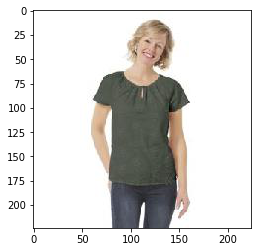

target    = ('longline',)
predicted = ('longline',)


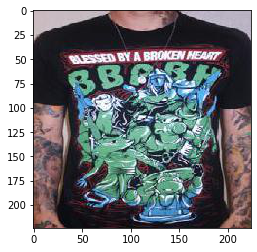

target    = ('baseball',)
predicted = ('baseball',)


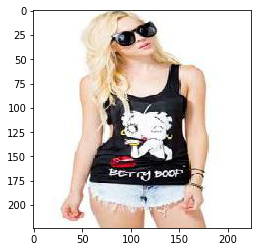

target    = ('stripe',)
predicted = ('stripe',)

good
====


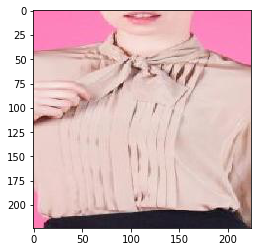

target    = ('hooded', 'zip')
predicted = ('zip',)


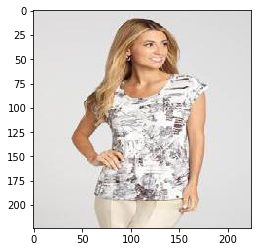

target    = ('abstract', 'abstract print', 'eiffel', 'print', 'scoop', 'shoulder', 'tower')
predicted = ('print',)


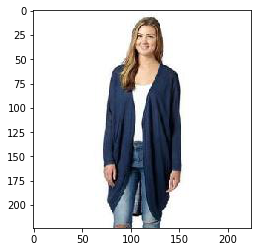

target    = ('love', 'marled', 'pocket', 'zip')
predicted = ('marled',)

none
====


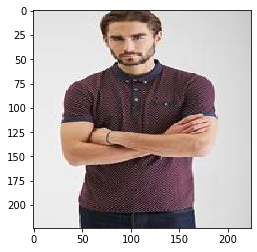

target    = ('hooded', 'shark')
predicted = ()


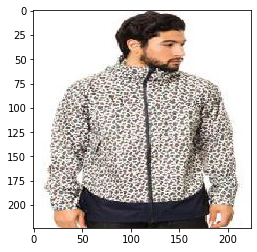

target    = ('crew', 'crew neck', 'fair', 'fair isle', 'isle')
predicted = ()


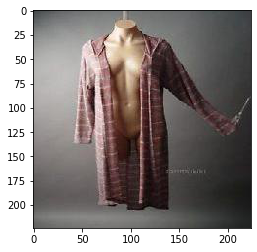

target    = ('beaded', 'chiffon', 'sheer', 'trim')
predicted = ()

horrible


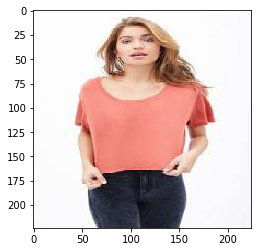

target    = ('linen', 'striped')
predicted = ('knit',)


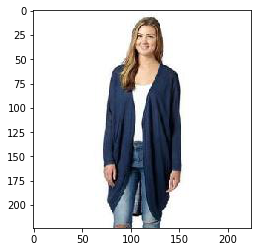

target    = ('longline', 'red')
predicted = ('marled',)


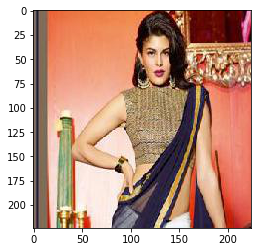

target    = ('embroidered',)
predicted = ('chiffon',)


In [21]:
import matplotlib.pyplot as plt

for key, values in interesting_results.items():
    print_header(key, level=0)
    for idx, value in enumerate(values):
        plt.imshow(value['X_val'] / 255)
        plt.show()
        print(f'target    = {value["y_val"]}')
        print(f'predicted = {value["y"]}')

### Resultados

In [22]:
from itertools import product

filename_format = '{base_net}_e{epochs:d}_w{weight:d}_ds{ds_size:d}.csv'
for base_net, epochs, weight, ds_size in product(
    ['VGG16', 'MobileNetV2', 'ResNet50V2'],
    [20, 40, 100],
    [1, 10, 100, 1000],
    [1000, 5000, 10000, 50000, 100000, 200000]
):
    params = dict(
        dataset_size=ds_size,
        base_net=base_net,
        base_net_params=dict(
            input_shape=IMG_SHAPE,
            include_top=True,
            weights='imagenet',
            classes=n_labels
        ),
        optimizer_name='Adam',
        optimizer_params=dict(
            lr=1e-4,
            beta_1=0.9,
            beta_2=0.999
        ),
        loss='binary_crossentropy',
        negative_class_weight=1,
        # positive_class_weight=100,
        positive_class_weight=weight,
        metrics_names=['accuracy', 'f1_score'],
        fit_params=dict(
            epochs=epochs,
            workers=6,
        )
    )

    results_file_name = filename_format.format(base_net=base_net, epochs=epochs, weight=weight, ds_size=ds_size)
    path = manager.model_path({'creator': model_creator.creator_name, 'parameters': params}, include=False)
    history_path = path.with_name(path.name + '.history')
    if history_path.exists():
        print(results_file_name)

        hist = load_pkl(history_path)
        pd.DataFrame(hist).to_csv(keras_results_path / results_file_name, index=False)

VGG16_e20_w1_ds10000.csv
VGG16_e20_w1_ds50000.csv
VGG16_e20_w1_ds200000.csv
VGG16_e20_w10_ds10000.csv
VGG16_e20_w10_ds100000.csv
VGG16_e20_w100_ds10000.csv
VGG16_e20_w100_ds100000.csv
VGG16_e20_w1000_ds5000.csv
VGG16_e20_w1000_ds10000.csv
VGG16_e20_w1000_ds200000.csv
MobileNetV2_e20_w100_ds10000.csv
ResNet50V2_e20_w100_ds10000.csv
